## Objective

**Predicting revenue generated by each user** <br>
The goal with this report here is to show a clear way and necessary steps needed to be taken for similar analysis tasks. Hope you find it helpful!
<br>
This is a notebook with explanation for basic analysis. <br> 
I would appreciate your comments and feedback, if you see some mistakes or have suggestions for improvement of this note book. Otherwise, if you find it helpful throw me an upvote, so I'll cheer my day! :-)

## 1. Data Prepration

### a. Loading libraries

In [1]:
import time
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### b. Loading the dataset

For loading the dataframe with json fields I have used a snippet of the code from anther notebook. You can find the link in the references.[2]

In [2]:
def load_df(csv_path, nrows = None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters = {col: json.loads for col in json_cols},                                                                         
                         dtype = {'fullVisitorId': 'str'}, # Important!!
                         nrows = nrows)
    for col in json_cols:
        # for each column, flatten data frame such that the values of a single col are spread in different cols
        # This will use subcol as names of flat_col.columns
        flat_col = json_normalize(df[col])
        # Name the columns in this flatten data frame as col.subcol for tracability
        flat_col.columns = [f"{col}.{subcol}" for subcol in flat_col.columns]
        # Drop the json_col and instead add the new flat_col
        df = df.drop(col, axis = 1).merge(flat_col, right_index = True, left_index = True)
    return df

In [3]:
csv_train_path = 'train_v2.csv'
csv_test_path = 'test_v2.csv'

In [5]:
train.loc[:2]

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Summery

### a. Data visuzalization

In [6]:
cols = train.columns
cols

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
 

In [7]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype('float')
#To have it as a data frame with fullVisitorId and totals.transactionRevenue we need to reset_index(). Otherwise, it would return a serie
target = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
target[:4]

,fullVisitorId,totals.transactionRevenue
0,0000059488412965267,0.0
1,0000118334805178127,0.0
2,0000174067426171406,0.0
3,0000174453501096099,0.0


Text(0.5, 1.0, 'Natural logarithm of agregate revenue generated from each user')

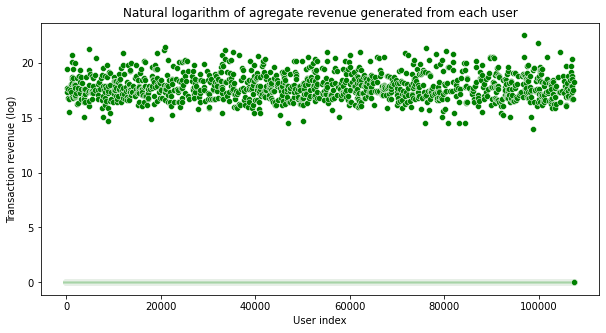

In [8]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.scatterplot(x = range(0, len(target)), y = np.log1p(target['totals.transactionRevenue']), color = 'g', marker = 'o')
ax.set_xlabel('User index')
ax.set_ylabel('Transaction revenue (log)')
ax.set_title('Natural logarithm of agregate revenue generated from each user')

In [9]:
train.fullVisitorId.nunique()

107402

There are 4000 records for 3710 users.

### b. Visualization for users generating revenue (target = 1)

Text(0.5, 0, 'Revenue')

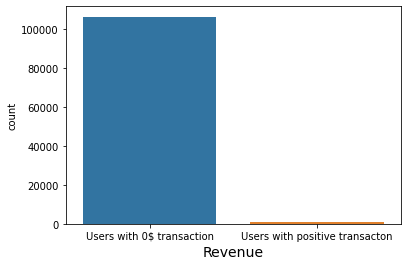

In [10]:
ax = sns.countplot(pd.cut(target['totals.transactionRevenue'],[-1,0,1e9]))
ax.set_xticklabels(['Users with 0$ transaction','Users with positive transacton'])
ax.set_xlabel('Revenue', fontsize = 14)

A very low percentage of users contribute in generating revenue. Let's have a closer look in them. To see how many they are and how do they contribute to the revenue generation.

In [11]:
temp_rev = target[target['totals.transactionRevenue'] != 0]
temp_rev.sort_values(by = 'totals.transactionRevenue', ascending = False)[:4]

,fullVisitorId,totals.transactionRevenue
96890,9026840718082010040,5.770790e+09
99881,9308310352918219134,2.933610e+09
20789,1957458976293878100,1.994890e+09
76170,7113011772090059658,1.748580e+09


In [12]:
print('number of users with transaction:',len(temp_rev))
print('number of total users:',len(target))
print('number of total transactions:', len(train))
print(np.round(np.sum(target['totals.transactionRevenue'] != 0)*100 / len(target),2), 'percent of users generate revenue!!')

number of users with transaction: 1188
number of total users: 107402
number of total transactions: 120000
1.11 percent of users generate revenue!!


Text(0.5, 0, 'Total sum of transaction from users contributing to revenue generation')

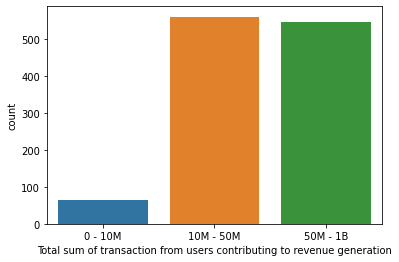

In [13]:
ax = sns.countplot(pd.cut(temp_rev['totals.transactionRevenue'],[0,1e7,0.5e8,1e9]))
ax.set_xticklabels(['0 - 10M','10M - 50M','50M - 1B'])
ax.set_xlabel('Total sum of transaction from users contributing to revenue generation')

16 out of 24 users have had a transaction between 10-50M dollars

In [14]:
train_trans_rev = train[train['totals.transactionRevenue'] > 0]
train_trans_non_rev = train[train['totals.transactionRevenue'].isna()]
len(train_trans_rev), len(train_trans_non_rev)

(1228, 118772)

### c. Some primary raw visualization
To see the distribution of different values for different features, I have added the count plot for some of the columns. Here, I first put all the columns from the trianing data, but then removed the ones that doesn't give an informative count plot. Therefore, only information about some of the columns are visualized here.

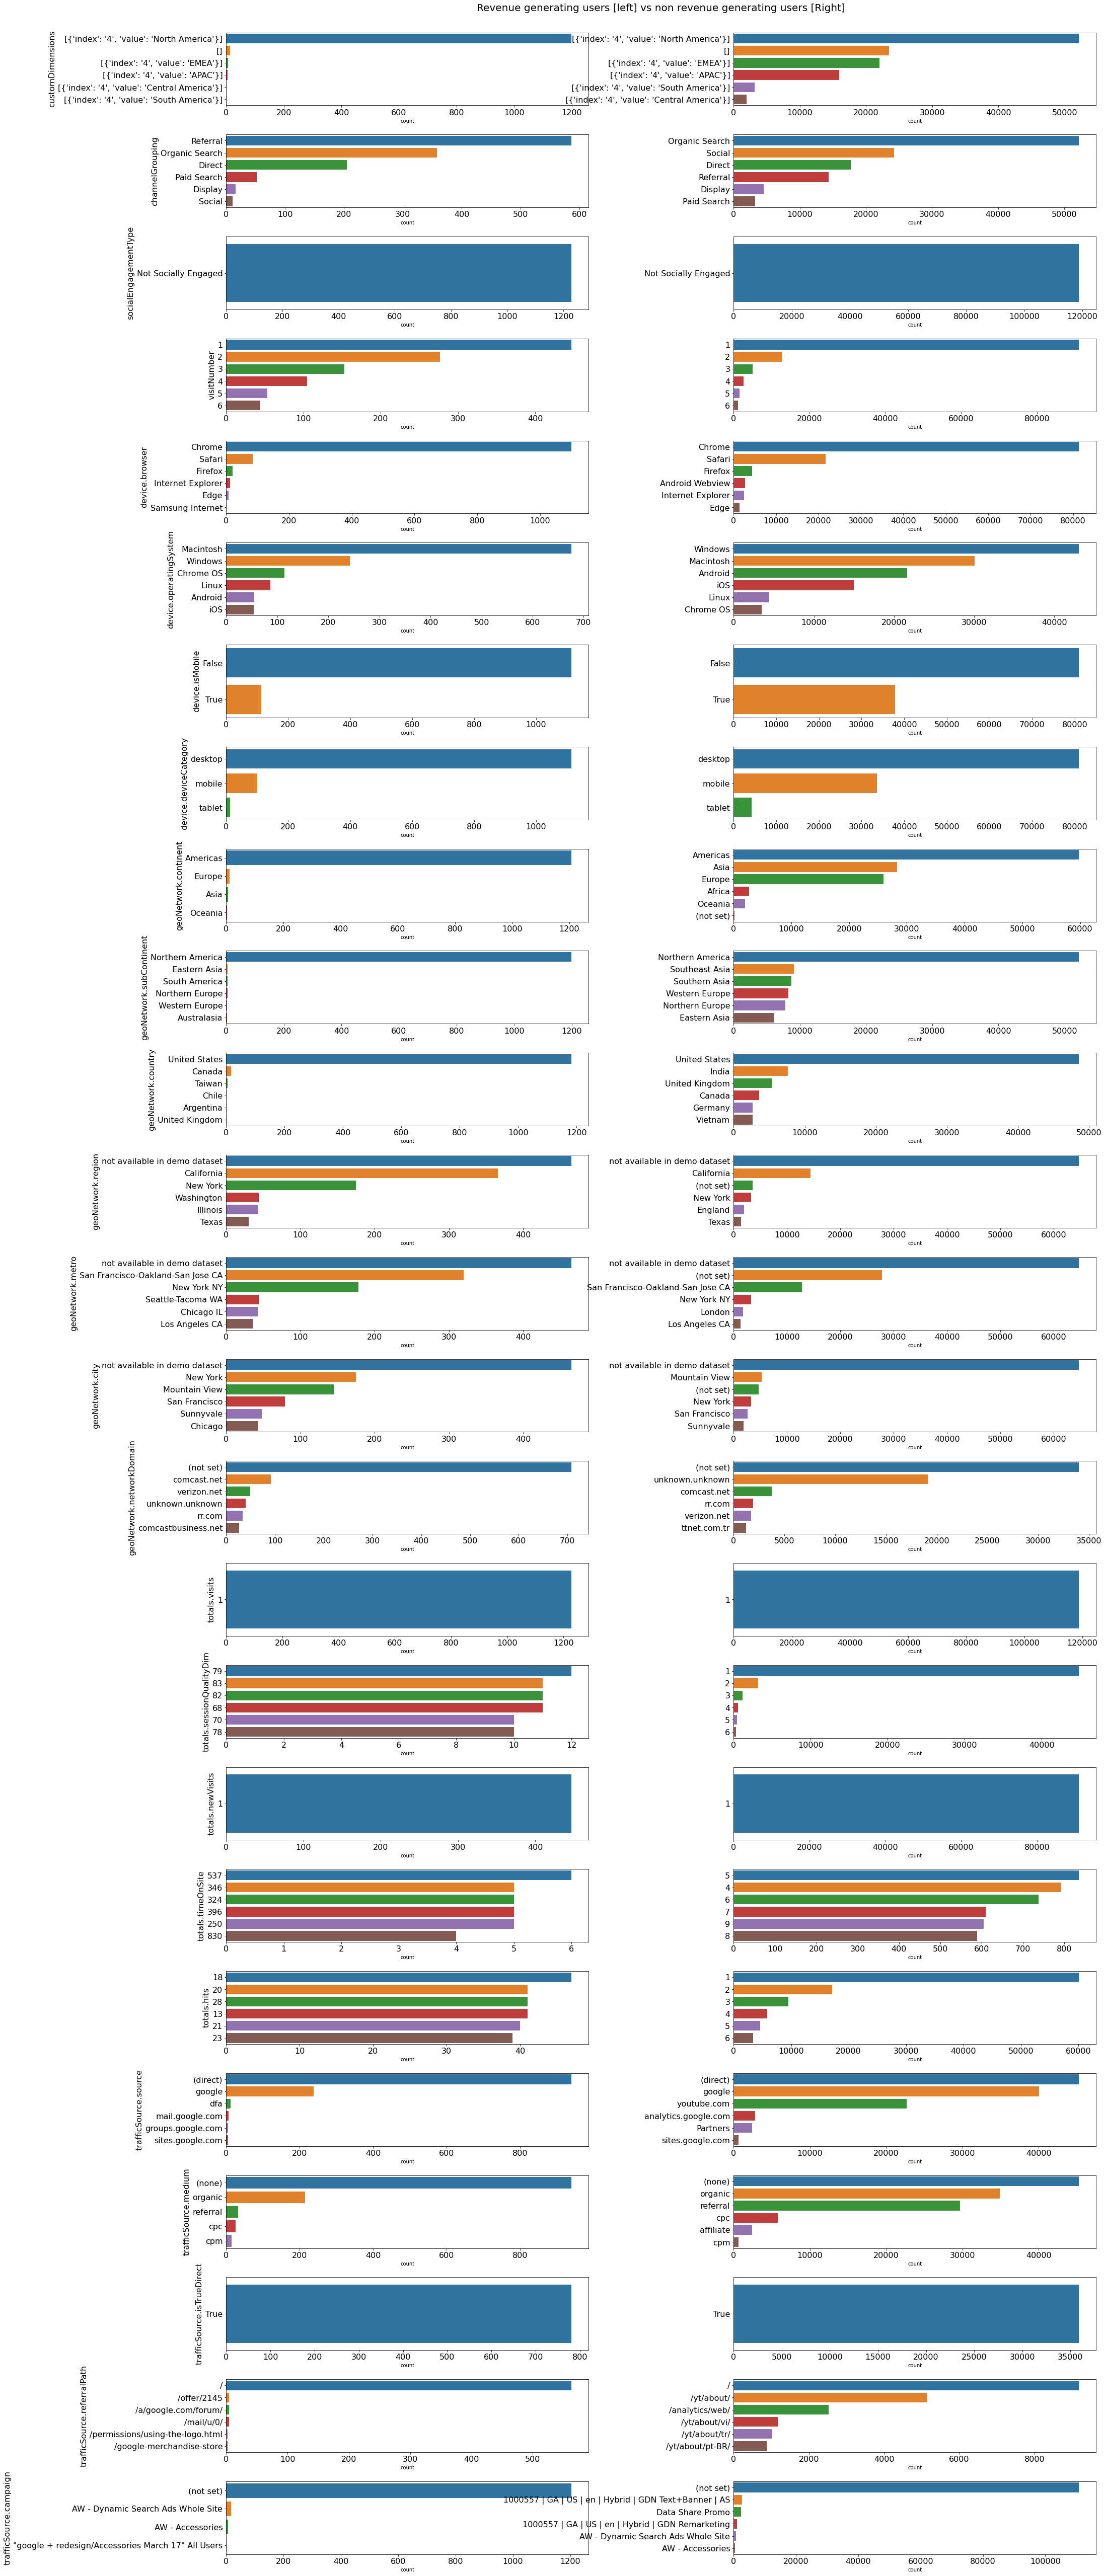

In [15]:
some_cols = ['customDimensions','channelGrouping', 'socialEngagementType', 'visitNumber',
       'device.browser', 'device.operatingSystem', 'device.isMobile','device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city','geoNetwork.networkDomain', 
       'totals.visits', 'totals.sessionQualityDim', 'totals.newVisits', 'totals.timeOnSite', 'totals.hits',
       'trafficSource.source', 'trafficSource.medium',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath', 'trafficSource.campaign'
       ]
fig, ax = plt.subplots(25, 2, figsize = (30,80))
#fig.tight_layout()
plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)
i = 0
for col in some_cols:
    sns.countplot(data = train_trans_rev, y = col, ax = ax[i,0], order = train_trans_rev[col].value_counts().iloc[:6].index) # Only the first top 6 value counts are shown
    ax[i,0].tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax[i,0].set_ylabel(col, fontsize = 16)
    sns.countplot(data = train_trans_non_rev, y = col, ax = ax[i,1], order = train_trans_non_rev[col].value_counts().iloc[:6].index) # Only the first top 6 value counts are shown
    ax[i,1].tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax[i,1].set_ylabel('', fontsize = 16)
    i += 1
fig.suptitle('Revenue generating users [left] vs non revenue generating users [Right]', fontsize = 20)
fig.subplots_adjust(top = 0.97)


### some insights from comparing the results between the users generating revenue vs other users
- Users generating revenue use Macintosh more than other users
- Their channel grouping is referral rather than organic search
- They use more Chrome
- They usually visit more than once
- Their network domain is less unknown.unkown
- They have higher time on site
- They have higher session quality dimension(*)
- Their total hits a lot higher
- They connect less by mobile devices or tablets and use more desktop
- They are mostly from US, rather than Europe, Asia or Africa
- They are usually connecting from California and NewYork
- They usually connect directly and less through google

(*)For calculating session quality dimension, user engagement is evaluated for each session, and the resulting proximity to conversion is expressed as a score of 1-100 for each session during the date range, with 1 being the farthest from and 100 being the closest to a transaction.

We also see some columns with constant values. We'll remove them when doing the data cleaning.

### d. Visualizing missing values

In [16]:
missing_val = pd.DataFrame()
for col in cols:
    na_count = train[col].isna().sum()
    if na_count != 0:
        missing_val.loc[col, 'NaN_val(%)'] = na_count/len(train)*100
print('Number of columns with missing values in train set:', len(missing_val))
missing_val.sort_values('NaN_val(%)', inplace = True)
missing_val[:5]

Number of columns with missing values in train set: 18


,NaN_val(%)
totals.pageviews,0.010000
totals.newVisits,23.768333
totals.bounces,49.532500
totals.timeOnSite,50.611667
totals.sessionQualityDim,54.761667


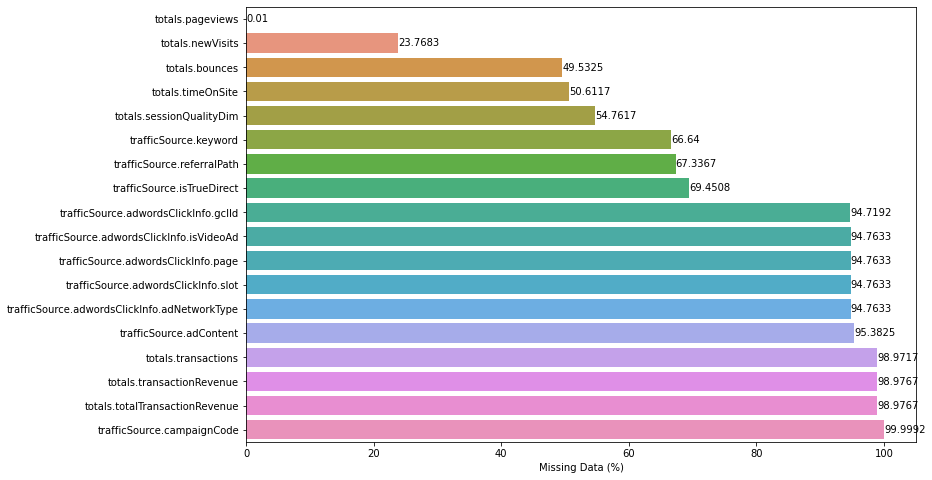

In [17]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(data = missing_val, x = 'NaN_val(%)', y = missing_val.index , ax = ax)
ax.set_xlabel('Missing Data (%)')
_ = ax.bar_label(ax.containers[0])

We see some columns with more than 50% missing values. We'll later remove them in data cleaning. <br>
totals.newVisits shows to have only nan and 1 as values. This is not informative. We'll remove that too.


### e. Constant columns

In [18]:
const_cols = []
for col in cols:
     if train[col].nunique() == 1: const_cols.append(col)
print('Number of columns with constant values:',len(const_cols))
const_cols

Number of columns with constant values: 24


['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

*totals.bounces, totals.newVisits, trafficSourcs.isTrueDirect* were among the missing value data. Lets have a closer look to them. 

In [19]:
train['totals.bounces'].unique()

array(['1', nan], dtype=object)

## 3. Data Cleaning

### a. Defining the target 

In [20]:
y_train_ = train['totals.transactionRevenue']
y_train_.fillna(0, inplace = True)
y_train_.astype('float')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119995    0.0
119996    0.0
119997    0.0
119998    0.0
119999    0.0
Name: totals.transactionRevenue, Length: 120000, dtype: float64

### b. Removing columns with missing values

In [21]:
missing_val[-4:]

,NaN_val(%)
totals.transactions,98.971667
totals.transactionRevenue,98.976667
totals.totalTransactionRevenue,98.976667
trafficSource.campaignCode,99.999167


This exact amount of threshold of Nan_value(%) for removing columns with missing values is chosen based on the plot from missing value. but roughly around 50% seems to be a reasonable choice. In the code block below I chose 48 as threshod. <br> Of course we should be carefull about which columns (features) we are removing. A way for keeping the columns is to replace the missing values with a reasonable replacement values. In this case for example we replaced the missing values in the transaction revevenues with 0.

In [22]:
for col in missing_val.index:
    if missing_val.loc[col, 'NaN_val(%)'] > 48: 
        train.drop(col, axis = 1, inplace = True)
    else: 
        train[col].fillna('0', inplace = True)
        test[col].fillna('0', inplace = True)

### c. Removing columns with constant values

In [23]:
for col in const_cols:
    if col not in missing_val.index:
        train.drop(col, axis = 1, inplace = True)

print('Number of columns in the training set',len(train.columns))

Number of columns in the training set 25


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   channelGrouping           120000 non-null  object
 1   customDimensions          120000 non-null  object
 2   date                      120000 non-null  int64 
 3   fullVisitorId             120000 non-null  object
 4   hits                      120000 non-null  object
 5   visitId                   120000 non-null  int64 
 6   visitNumber               120000 non-null  int64 
 7   visitStartTime            120000 non-null  int64 
 8   device.browser            120000 non-null  object
 9   device.operatingSystem    120000 non-null  object
 10  device.isMobile           120000 non-null  bool  
 11  device.deviceCategory     120000 non-null  object
 12  geoNetwork.continent      120000 non-null  object
 13  geoNetwork.subContinent   120000 non-null  object
 14  geoN

### d. Removing irrelavant features for building a model

In [25]:
irrelavant = ['fullVisitorId', 'visitId', 'trafficSource.campaign']
for col in irrelavant:
    train.drop(col, axis = 1, inplace = True)

## 4. Feature Engineering and outliers

### a. Handling datetime data types
Let's check the format of visitStartTime

In [26]:
train['visitStartTime']

0         1508198450
1         1508176307
2         1508201613
3         1508169851
4         1508190552
             ...    
119995    1481279935
119996    1481313954
119997    1481302828
119998    1481312070
119999    1481302596
Name: visitStartTime, Length: 120000, dtype: int64

In [27]:
for df in [train, test]:
    print(df['visitStartTime'][0])
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['rec_dayofweek'] = df['visitStartTime'].dt.dayofweek
    df['rec_hours'] = df['visitStartTime'].dt.hour
    df['rec_dayofmonth'] = df['visitStartTime'].dt.day
    print(df['visitStartTime'][0], df['rec_dayofweek'][0], train['rec_hours'][0], df['rec_dayofmonth'][0])
    df.drop('visitStartTime', axis = 1, inplace = True)

1508198450
2017-10-17 00:00:50 1 0 17
1526099341
2018-05-12 04:29:01 5 0 12


### b. Converting the categorical columns to numerical type
It is possible to use factorize method as well. Here we have oused label encoder to convert categorical data into numerical.

In [28]:
le = LabelEncoder()
print('Columns that are converted to numerical values with label encodedr:')
for col in train.columns:
    if train[col].dtype == 'O':
        print(col)
        #print(col, train[col].unique())
        train.loc[:, col] = le.fit_transform(train.loc[:, col])
        test.loc[:, col] = le.fit_transform(test.loc[:, col])

Columns that are converted to numerical values with label encodedr:
channelGrouping
customDimensions
hits
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
totals.hits
totals.pageviews
totals.newVisits
trafficSource.source
trafficSource.medium


In [29]:
for col in train.columns:
    train[col] = train[col].astype('float')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   channelGrouping           120000 non-null  float64
 1   customDimensions          120000 non-null  float64
 2   date                      120000 non-null  float64
 3   hits                      120000 non-null  float64
 4   visitNumber               120000 non-null  float64
 5   device.browser            120000 non-null  float64
 6   device.operatingSystem    120000 non-null  float64
 7   device.isMobile           120000 non-null  float64
 8   device.deviceCategory     120000 non-null  float64
 9   geoNetwork.continent      120000 non-null  float64
 10  geoNetwork.subContinent   120000 non-null  float64
 11  geoNetwork.country        120000 non-null  float64
 12  geoNetwork.region         120000 non-null  float64
 13  geoNetwork.metro          120000 non-null  f

We'll remove all the columns that are in test set but not in train set. 

In [31]:
fullvisitorid = []
for col in test.columns:
    if col == 'fullVisitorId':
        fullvisitorid = test[col] 
    if col not in train.columns:
        test.drop(col, axis = 1, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   channelGrouping           401589 non-null  int64
 1   customDimensions          401589 non-null  int64
 2   date                      401589 non-null  int64
 3   hits                      401589 non-null  int64
 4   visitNumber               401589 non-null  int64
 5   device.browser            401589 non-null  int64
 6   device.operatingSystem    401589 non-null  int64
 7   device.isMobile           401589 non-null  bool 
 8   device.deviceCategory     401589 non-null  int64
 9   geoNetwork.continent      401589 non-null  int64
 10  geoNetwork.subContinent   401589 non-null  int64
 11  geoNetwork.country        401589 non-null  int64
 12  geoNetwork.region         401589 non-null  int64
 13  geoNetwork.metro          401589 non-null  int64
 14  geoNetwork.city     

In [32]:
for col in test.columns:
    test[col] = test[col].astype('float')

## 5. Model Training

### Defining the model

In [33]:
model = lgb.LGBMRegressor(
        num_leaves = 31,  #(default = 31) – Maximum tree leaves for base learners.
        learning_rate = 0.03, #(default = 0.1) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using 
                              #reset_parameter callback. Note, that this will ignore the learning_rate argument in training.
        n_estimators = 1000, #(default = 100) – Number of boosted trees to fit.
        subsample = .9, #(default = 1.) – Subsample ratio of the training instance.
        colsample_bytree = .9, #(default = 1.) – Subsample ratio of columns when constructing each tree
        random_state = 34
)

### Splitting the train set and validation set
Since in real cases we have access to the data up to a certain date, and then we should predict the transactions for future, we'll pick a date for splitting to data into training set and validaton set. We will later remove the column related to date.

In [34]:
train['date'].min(), train['date'].max()

(20160811.0, 20180429.0)

In [35]:
x_train = train[ train['date'] < 20171101 ]
x_valid = train[ train['date'] >= 20171101 ]
print('Number of samples in train set:', len(x_train))
print('Number of samples in validation set:',len(x_valid))

Number of samples in train set: 84825
Number of samples in validation set: 35175


In [36]:
y_train_len = len(x_train)
y_train = y_train_[:y_train_len]
y_valid = y_train_[y_train_len:]

In [37]:
x_train.drop('date', axis = 1, inplace = True)
x_valid.drop('date', axis = 1, inplace = True)

### Trainnig the model

To make sure we have the same length for x_train and y_train as well as x_valid and y_valid

In [38]:
print(len(x_train), len(y_train))
print(len(x_valid), len(y_valid))

84825 84825
35175 35175


In [39]:
 model.fit(
        x_train, np.log1p(y_train),
        eval_set = [(x_valid, np.log1p(y_valid))],
        early_stopping_rounds = 50,
        verbose = 100,
        eval_metric = 'rmse'
    )

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.74136	valid_0's l2: 3.03235


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, n_estimators=1000,
              random_state=34, subsample=0.9)

### Feature importance

In [40]:
feat_impr = pd.DataFrame()
feat_impr['feature'] = x_train.columns
feat_impr['importance'] = model.booster_.feature_importance(importance_type = 'gain')
feat_impr.sort_values(by = 'importance', ascending = False)[:10]

,feature,importance
22,rec_dayofmonth,2184.051979
2,hits,1370.217010
0,channelGrouping,1077.901001
20,rec_dayofweek,566.035995
5,device.operatingSystem,354.673996
16,totals.pageviews,265.623993
13,geoNetwork.city,192.095993
9,geoNetwork.subContinent,173.393005
14,geoNetwork.networkDomain,172.865005
21,rec_hours,135.039993


<AxesSubplot:xlabel='importance', ylabel='feature'>

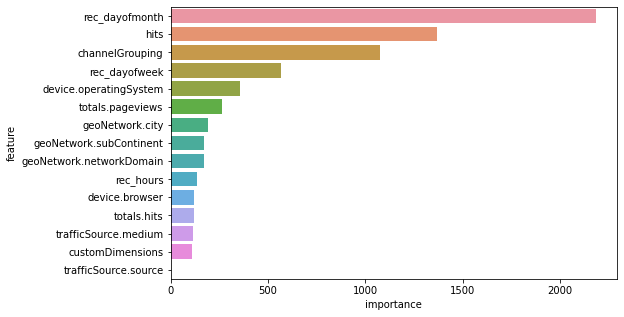

In [41]:
plt.figure(figsize = (8,5))
sns.barplot(x = 'importance', y = 'feature', data = feat_impr.sort_values('importance', ascending = False)[:15])


### a. For each record (row) of data

In [42]:
valid_preds = .predict(x_valid, num_iteration = model.best_iteration_)
valid_preds[valid_preds < 0] = 0

In [43]:
mean_squared_error(np.log1p(y_valid), valid_preds)

3.032350405032811